# Twitter Sentiment Analysis

This corpus is a monolingual resource of unique tweets about product reviews, with each tweet paired with an adversarial sentence. Both original and adversarial tweets are manually and automatically annotated according to sentiment polarity (positive, negative, neutral). The objective is to compare and evaluate both types of annotation.

In [1]:
!pip install transformers

In [2]:
!pip install tweepy --upgrade

## Get Tweets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/LAP/Subjects/BLR/Project/twitter-sentiment

/content/drive/MyDrive/LAP/Subjects/BLR/Project/twitter-sentiment


In [5]:
import tweepy

with open("auth.txt") as f:
    bearer_token = f.read().split()[2]

client = tweepy.Client(bearer_token=bearer_token)
#Interests and Hobbies Vertical:Technology
query = 'context:65.848920371311001600 lang:en -is:retweet -is:quote -is:reply -has:links'
end_time = '2022-02-01T00:00:00Z'
# tweet_fields = ['context_annotations', 'entities', 'created_at']
tweet_fields = []

tweets = client.search_recent_tweets(query=query, tweet_fields=tweet_fields, end_time=end_time, max_results=100)

for i, tweet in enumerate(tweets.data):
    print("TWEET", i)
    print(tweet.text)
    print()

TWEET 0
just put a CD into my MacBook to burn it and my computer is literally trembling with reawakened recognition 😆

TWEET 1
oh yeah tesla well what about a car that just logs into your tiktok acct and drives you to starbucks

TWEET 2
#100DaysOfCode Haven’t updated in a while due to not feeling well, just been reviewing some HTML/CSS &amp; JavaScript until I feel better to take on new concepts

Also been watching mock interviews  :)

TWEET 3
Finally managed to move my business email from google hosting to another host. So stressful and difficult. The whole internet is so hard! At least the metaverse is coming, I'm confident that will make everything easy and good, phew.

TWEET 4
why do I have to take a thermodynamics class when some people are about to meet ateez life is so unfair

TWEET 5
MetroPCS is cutting those on EBB program early. Don't use MetroPCS. 
#metropcs
#Metroabandonsebb

TWEET 6
You are currently using Linux &lt;3.

TWEET 7
All the software I create will be free and op

In [6]:
import pandas as pd
tweets_df = pd.DataFrame(tweets.data)
tweets_df

,id,text
0,1488301060334759939,just put a CD into my MacBook to burn it and m...
1,1488301057650438144,oh yeah tesla well what about a car that just ...
2,1488301040160043008,#100DaysOfCode Haven’t updated in a while due ...
3,1488301015514288131,Finally managed to move my business email from...
4,1488301011865419780,why do I have to take a thermodynamics class w...
...,...,...
94,1488300155384340483,Today I will start my journey in HTB and Pytho...
95,1488300147876540420,16 inch MacBook Pro: the keyboard is set back ...
96,1488300141748846592,Thinking about how my laptop used to not be ab...
97,1488300127706099716,yeah starting my first salaried job is cool bu...


## TweetEval

https://arxiv.org/pdf/2010.12421.pdf

https://github.com/cardiffnlp/tweeteval

In [9]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(tweets):
    new_tweets = []
    for text in tweets:
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        new_tweets.append(" ".join(new_text))
    return new_tweets

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary
def get_params(task):
    name = f"cardiffnlp/twitter-roberta-base-{task}"

    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModelForSequenceClassification.from_pretrained(name)

    # download label mapping
    labels=[]
    mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
    with urllib.request.urlopen(mapping_link) as f:
        html = f.read().decode('utf-8').split("\n")
        csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

    return model, tokenizer, labels

# Predict task
def predict(text, model, tokenizer, labels, task):
    prep_text = preprocess(text)
    text_sents = []
    for text in prep_text:
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        ranking = np.argsort(scores)
        ranking = ranking[::-1]
        sents = {}
        sents[task] = labels[ranking[0]]
        for i in range(scores.shape[0]):
            sents[labels[ranking[i]]] = round(scores[ranking[i]], 3)
        text_sents.append(sents)
    return text_sents

### Sentiment

In [10]:
task = 'sentiment'
model_sentiment, tokenizer_sentiment, labels_sentiment = get_params(task)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [ ]:
sentiment = predict(list(tweets_df["text"]), model_sentiment, tokenizer_sentiment, labels_sentiment, task)

In [12]:
sent = [sent['sentiment'] for sent in sentiment]
negative = [sent['negative'] for sent in sentiment]
neutral = [sent['neutral'] for sent in sentiment]
positive = [sent['positive'] for sent in sentiment]

In [20]:
tweets_df['sentiment'] = sent
tweets_df['negative'] = negative
tweets_df['neutral'] = neutral
tweets_df['positive'] = positive
tweets_df

,id,text,sentiment,negative,neutral,positive,emotion,sadness
0,1488301060334759939,just put a CD into my MacBook to burn it and m...,positive,0.070,0.398,0.532,joy,0.022
1,1488301057650438144,oh yeah tesla well what about a car that just ...,neutral,0.241,0.655,0.104,joy,0.086
2,1488301040160043008,#100DaysOfCode Haven’t updated in a while due ...,neutral,0.261,0.500,0.238,sadness,0.691
3,1488301015514288131,Finally managed to move my business email from...,positive,0.147,0.296,0.557,optimism,0.066
4,1488301011865419780,why do I have to take a thermodynamics class w...,negative,0.966,0.031,0.002,anger,0.026
...,...,...,...,...,...,...,...,...
94,1488300155384340483,Today I will start my journey in HTB and Pytho...,positive,0.002,0.089,0.909,optimism,0.024
95,1488300147876540420,16 inch MacBook Pro: the keyboard is set back ...,neutral,0.335,0.381,0.284,sadness,0.393
96,1488300141748846592,Thinking about how my laptop used to not be ab...,negative,0.585,0.378,0.036,sadness,0.874
97,1488300127706099716,yeah starting my first salaried job is cool bu...,positive,0.001,0.026,0.972,joy,0.010


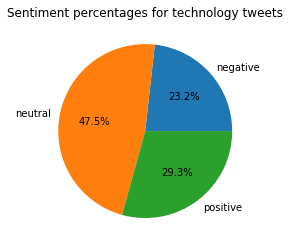

In [30]:
negative_count = sent.count('negative')
neutral_count = sent.count('neutral')
positive_count = sent.count('positive')
plt.pie(x = [negative_count, neutral_count, positive_count], labels=labels_sentiment, autopct='%1.1f%%')
plt.title("Sentiment percentages for technology tweets")
plt.show()

### Emotion

In [14]:
task = 'emotion'
model_emotion, tokenizer_emotion, labels_emotion = get_params(task)

Downloading:   0%|          | 0.00/779 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [ ]:
emotion = predict(list(tweets_df["text"]), model_emotion, tokenizer_emotion, labels_emotion, task)

In [16]:
emot = [emot['emotion'] for emot in emotion]
anger = [emot['anger'] for emot in emotion]
joy = [emot['joy'] for emot in emotion]
optimism = [emot['optimism'] for emot in emotion]
sadness = [emot['sadness'] for emot in emotion]

In [21]:
tweets_df['emotion'] = emot
tweets_df['anger'] = anger
tweets_df['joy'] = joy
tweets_df['optimism'] = optimism
tweets_df['sadness'] = sadness
tweets_df

,id,text,sentiment,negative,neutral,positive,emotion,sadness,anger,joy,optimism
0,1488301060334759939,just put a CD into my MacBook to burn it and m...,positive,0.070,0.398,0.532,joy,0.022,0.023,0.921,0.034
1,1488301057650438144,oh yeah tesla well what about a car that just ...,neutral,0.241,0.655,0.104,joy,0.086,0.416,0.450,0.048
2,1488301040160043008,#100DaysOfCode Haven’t updated in a while due ...,neutral,0.261,0.500,0.238,sadness,0.691,0.015,0.216,0.078
3,1488301015514288131,Finally managed to move my business email from...,positive,0.147,0.296,0.557,optimism,0.066,0.048,0.185,0.701
4,1488301011865419780,why do I have to take a thermodynamics class w...,negative,0.966,0.031,0.002,anger,0.026,0.960,0.006,0.007
...,...,...,...,...,...,...,...,...,...,...,...
94,1488300155384340483,Today I will start my journey in HTB and Pytho...,positive,0.002,0.089,0.909,optimism,0.024,0.033,0.377,0.567
95,1488300147876540420,16 inch MacBook Pro: the keyboard is set back ...,neutral,0.335,0.381,0.284,sadness,0.393,0.154,0.295,0.159
96,1488300141748846592,Thinking about how my laptop used to not be ab...,negative,0.585,0.378,0.036,sadness,0.874,0.093,0.019,0.014
97,1488300127706099716,yeah starting my first salaried job is cool bu...,positive,0.001,0.026,0.972,joy,0.010,0.019,0.920,0.051


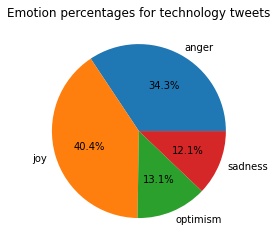

In [31]:
anger_count = emot.count('anger')
joy_count = emot.count('joy')
optimism_count = emot.count('optimism')
sadness_count = emot.count('sadness')
plt.pie(x = [anger_count, joy_count, optimism_count, sadness_count], labels=labels_emotion, autopct='%1.1f%%')
plt.title("Emotion percentages for technology tweets")
plt.show()

## Wordclouds

In [37]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
def create_wordcloud(text):
    wc = WordCloud(max_words=3000,
        stopwords=STOPWORDS,
        repeat=True)
    wc.generate(str(text))
    plt.figure(figsize=(10, 10))
    plt.imshow(wc)
    plt.axis("off")

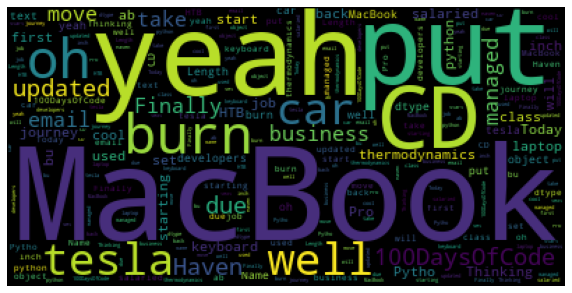

In [38]:
create_wordcloud(tweets_df["text"])

### Sentiment

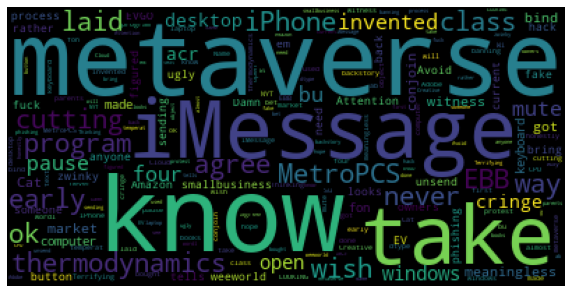

In [39]:
create_wordcloud(tweets_df[tweets_df["sentiment"] == "negative"]["text"])

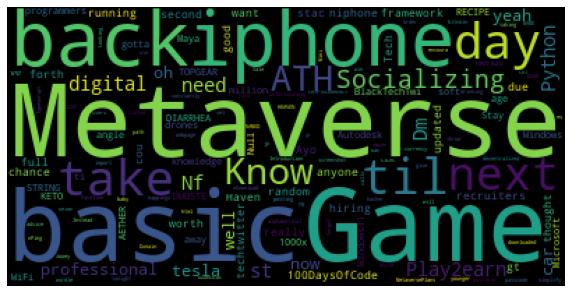

In [40]:
create_wordcloud(tweets_df[tweets_df["sentiment"] == "neutral"]["text"])

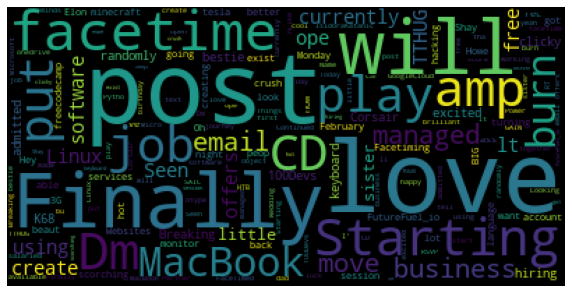

In [41]:
create_wordcloud(tweets_df[tweets_df["sentiment"] == "positive"]["text"])

### Emotion

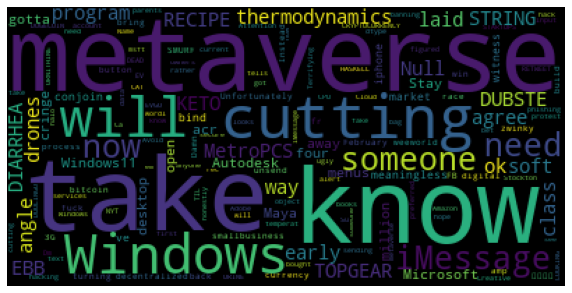

In [43]:
create_wordcloud(tweets_df[tweets_df["emotion"] == "anger"]["text"])

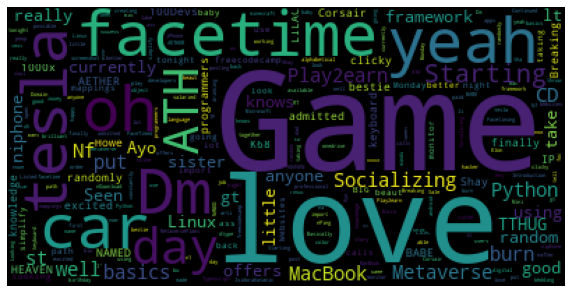

In [44]:
create_wordcloud(tweets_df[tweets_df["emotion"] == "joy"]["text"])

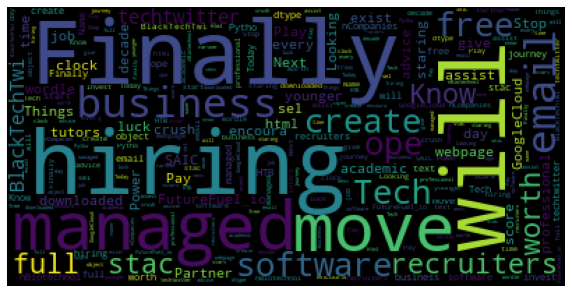

In [45]:
create_wordcloud(tweets_df[tweets_df["emotion"] == "optimism"]["text"])

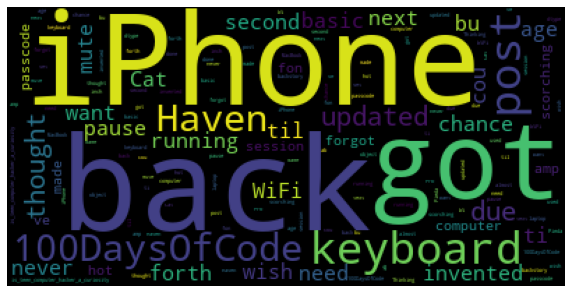

In [42]:
create_wordcloud(tweets_df[tweets_df["emotion"] == "sadness"]["text"])